## Init setup

In [3]:
from ast import mod
import pathlib
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple
import torchio as tio
import torch
import matplotlib.pyplot as plt
import os
import data
from data.datasets import MedicalDecathlonDataset, BrainTumourDataset
from utils.assertions import ensure

from pathlib import Path
from time import time
import nibabel as nib
from utils.metrics import dice_coefficient, dice_coefficient_classes
from utils.utils import setup_seed
from hydra.utils import instantiate
import os
from data.datasets import MedicalDecathlonDataset
import torch.nn.functional as F

def model_params(model_dir_str):
	model_dir = Path(model_dir_str)
	if not model_dir.is_dir():
		raise FileNotFoundError(f"Model directory not found: {model_dir}")
	
	model_path = f"{model_dir}/best_model.pth"
	cfg = OmegaConf.load(f"{model_dir}/config.yaml")

	if not isinstance(cfg, DictConfig):
		raise TypeError("cfg must be a DictConfig.")

	return model_path, cfg


## Datasimulation 
### DataSimulation -- Our model

In [2]:


# model_dir_str = "trained_models/ms-unet3d/Task04_Hippocampus/2025-05-05_12-17-39"
model_dir_str = "trained_models/ms-unet3d/Task04_Hippocampus/2025-05-07_15-16-30"

model_path, cfg = model_params(model_dir_str)
scales = [0, 1, 2, 3, 4]

base_dir = Path(cfg.dataset.base_path)

datasets = {}

for scale in scales:
	img_dir = base_dir / "imagesTs" / f"scale{scale}"
	lbl_dir = base_dir / "labelsTs" / f"scale{scale}"
	img_dir_sort = sorted(os.listdir(img_dir))
	lbl_dir_sort = sorted(os.listdir(lbl_dir))
	dataset = MedicalDecathlonDataset(cfg, "test", img_dir_sort, lbl_dir_sort, str(img_dir), str(lbl_dir))
	datasets[scale] = dataset


setup_seed(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = instantiate(cfg.architecture.path, cfg)

checkpoint = torch.load(model_path, map_location=device)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

results_per_scale = {scale: [] for scale in scales}
# print("******************* TEST 1 *******************")
# print("THIS ASSUMES DATASET IS TARGET_SHAPE I THINK? I REMOVED THE TARGET SHAPE PADDING TO TEST BELOW TEST 2...")
# for image, label in datasets[0]:
# 	image_tensor = image.unsqueeze(0).to(device)
# 	segs, _ = model(image_tensor)
# 	for i in range(len(segs)):
# 		print(f"[Scale {i} | Image Shape {segs[i].shape}")
# 		preds = segs[i]
# 		pred = torch.argmax(preds, dim=1).squeeze(0)
# 		label = label.squeeze(0).to(device)
# 		downsampled_label = F.interpolate(
# 					label.unsqueeze(0).unsqueeze(0).float(),
# 					size=pred.shape,
# 					mode="nearest",
# 				).squeeze(0).squeeze(0)
# 		d = dice_coefficient(
# 			pred, downsampled_label, num_classes=cfg.dataset.num_classes, ignore_index=0
# 		)
# 		results_per_scale[i] += [d.item()]
  
  
# print("Results per scale:")
# for scale, results in results_per_scale.items():
# 	print(f"Scale {scale}: {results}")
# 	mean_dice = np.mean(results)
# 	std_dice = np.std(results)
# 	print(f"Mean Dice: {mean_dice:.4f}, Std Dice: {std_dice:.4f}")


results_per_scale = {scale: [] for scale in scales}
print("******************* TEST 2 *******************")
for scale in scales:
	with torch.no_grad():
		for image, label in datasets[scale]:
			image_tensor = image.unsqueeze(0).to(device)


			# print(image.shape)
			# print(f"[Scale {scale} | Image Shape {image_tensor.shape}")
			# print(f"[Scale {scale} | Label Shape nig {label.shape}")

			output = model.run_inference(image_tensor)
   
			label = label.squeeze(0).to(device)
			pred = torch.argmax(output, dim=1)
			d = dice_coefficient(
				pred, label, num_classes=cfg.dataset.num_classes, ignore_index=0
			)
			results_per_scale[scale] += [d.item()]


print("Results per scale:")
for scale, results in results_per_scale.items():
    print(f"Scale {scale}: {results}")
    mean_dice = np.mean(results)
    std_dice = np.std(results)
    print(f"Mean Dice: {mean_dice:.4f}, Std Dice: {std_dice:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/Task04_Hippocampus_Scaled/imagesTs/scale0'

### DataSimulation -- BackBone

## Show the segmentation

In [ ]:
from ast import mod
import pathlib
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple

import torch
import matplotlib.pyplot as plt
from hydra.utils import instantiate

import data
from data.datasets import MedicalDecathlonDataset, BrainTumourDataset
from utils.assertions import ensure


# ------ Change only this for test of a trained model ------
# model_dir_str = "trained_models/ms-unet3d/Task04_Hippocampus/2025-04-24_14-52-40"
model_dir_str = "trained_models/ms-unet3d/Task01_BrainTumour/2025-05-07_19-45-45"
# ----------------------------------------------------------


model_dir = pathlib.Path(model_dir_str)
if not model_dir.is_dir():
    raise FileNotFoundError(f"Model directory not found: {model_dir}")

model_path = f"{model_dir}/best_model.pth"
cfg = OmegaConf.load(f"{model_dir}/config.yaml")


try:
    path_parts = model_dir.parts
    # model_architechture = path_parts[-3]
    task_name = path_parts[-2]
    inference_model_name = path_parts[-1]
except IndexError:
    raise ValueError(f"Could not parse architecture/task/name from model_dir: {model_dir}. Expected structure like 'trained_models/arch/task/name'")

if not isinstance(cfg, DictConfig):
    raise TypeError("cfg must be a DictConfig.")

if task_name == "Task04_Hippocampus":
    dataset = MedicalDecathlonDataset(cfg, "test")
elif task_name == "Task01_BrainTumour":
    dataset = BrainTumourDataset(cfg, "test") 
else:
    raise ValueError(f"Unknown task name: {task_name}. Expected 'Task04_Hippocampus' or 'Task01_BrainTumour'.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = instantiate(cfg.architecture.path, cfg)

checkpoint = torch.load(model_path, map_location=device)
model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model.to(device)  # Move the model to the appropriate device
model.eval()


#samples idx list to check: (6,)
sample_idx = 0

# ... after dataset creation ...
print(f"Dataset size (test phase): {len(dataset)}")
ensure(len(dataset) > 0, Exception, "Dataset is empty!")

sample_idx = min(len(dataset)-1, 392) 
image, gt = dataset[sample_idx]
# ... rest of the code ...

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)

# Add batch dimension and move to device
image_batch = image.unsqueeze(0).to(device)  # shape: (1, C, D, H, W)
print(f"Image shape: {image_batch.shape}")
# Run inference
with torch.no_grad():
    output = model(image_batch)
    # If model returns deep supervision outputs, take the final prediction
    if isinstance(output, (tuple, list)):
        output = output[0]
    # Get predicted labels: (B, D, H, W)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu()  

# Convert tensors to numpy arrays for visualization
# Remove channel dimension from image for visualization: (D, H, W)
image_np = image.squeeze(0).cpu().numpy()
gt_np = gt.cpu().numpy()
pred_np = pred.numpy()

# Choose 3 slices evenly spaced along the depth dimension
depth = image_np.shape[0]
num_slices = min(depth, 66)
slice_indices = np.linspace(0, depth-1, num=num_slices, dtype=int)


# Create subplots: one row per slice and 3 columns for image, ground truth, and prediction
fig, axes = plt.subplots(nrows=num_slices, ncols=3, figsize=(12, 4 * num_slices))
for i, slice_idx in enumerate(slice_indices):
    slice_2d = image_np[slice_idx]
    # slice_2d = np.rot90(slice_2d)
    axes[i, 0].imshow(slice_2d, cmap="gray")
    axes[i, 0].set_title(f"Image Slice {slice_idx}")
    
    gt_2d = gt_np[slice_idx]
    # gt_2d = np.rot90(gt_2d)
    axes[i, 1].imshow(gt_2d, cmap="grey", vmin=0, vmax=cfg.dataset.num_classes - 1)

    axes[i, 1].set_title(f"Ground Truth Slice {slice_idx}")
    pred_2d = pred_np[slice_idx]
    # pred_2d = np.rot90(pred_2d)
    axes[i, 2].imshow(pred_2d, cmap="grey", vmin=0, vmax=cfg.dataset.num_classes - 1)
    axes[i, 2].set_title(f"Prediction Slice {slice_idx}")

    # for ax in axes[i]:
    #     ax.axis("off")



plt.tight_layout()
plt.show()

Dataset size (test phase): 484
Image shape: torch.Size([1, 4, 155, 240, 240])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 18 but got size 19 for tensor number 1 in the list.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.__config__ import show

import matplotlib.pyplot as plt
import numpy as np

def show_prediction(image, gt_mask, pred_mask, slice_idx=None, class_id=1):
    gt_binary = (gt_mask == class_id)
    pred_binary = (pred_mask == class_id)

    if slice_idx is None:
        z_coords = np.where(gt_binary)[0]
        slice_idx = z_coords[len(z_coords)//2] if len(z_coords) > 0 else gt_mask.shape[0] // 2

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image[slice_idx], cmap='gray')
    plt.title("MRI Slice")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_binary[slice_idx], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_binary[slice_idx], cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    error_map = np.logical_xor(gt_binary[slice_idx], pred_binary[slice_idx])
    plt.imshow(error_map, cmap='Reds')
    plt.title("Error Map")
    plt.axis('off')

    plt.suptitle(f"Class {class_id} - Slice {slice_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


show_prediction(image_np, gt_np, pred_np, class_id=1)


## Visualization of images!

### Setup

In [ ]:
from ast import mod
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple

import torch
import matplotlib.pyplot as plt

import data
from data.datasets import MedicalDecathlonDataset, BrainTumourDataset
from models.ms_unet3d import MSUNet3D

# ras+ ORIENTATION
# class imbalance

# task_name = "Task04_Hippocampus"
task_name = "Task01_BrainTumour"
inference_model_name = "2025-03-31_13-44-04"

model_dir = f"trained_models/unet3d/{task_name}/{inference_model_name}"
model_path = f"{model_dir}/best_model.pth"

cfg = OmegaConf.load(f"{model_dir}/config.yaml")

if not isinstance(cfg, DictConfig):
    raise TypeError("cfg must be a DictConfig.")

dataset = MedicalDecathlonDataset(cfg, phase="test")
# dataset = BrainTumourDataset(cfg, phase='train')

model = MSUNet3D(
    in_channels=1,
    num_classes=cfg.dataset.num_classes,
    n_filters=cfg.model.n_filters,
    dropout=cfg.training.dropout,
    batch_norm=True,
    inference_fusion_mode=cfg.model.deep_supervision.inference_fusion_mode,
    depth=cfg.model.depth,
    deep_supervision_levels=cfg.model.deep_supervision.levels
)



ModuleNotFoundError: No module named 'models.ms_unet3d'

### Visualize predetermined sample and random slices

In [ ]:
sample_idx = 300
print(dataset)
image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)
slice = 104 # or 126

# three random slices
# Pick three random slices along the depth dimension
depth = image.shape[3]
slices = np.random.choice(depth, size=3, replace=False)

# Plot the slices
for i, slice_idx in enumerate(slices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image[0, :, :, slice_idx], cmap='gray')
    plt.title(f"Slice {slice_idx}")
    plt.axis('off')
plt.show()

IndexError: list index out of range

### Visualize predetermined sample and slice

In [ ]:
sample_idx = 300

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)
slice = 104 # or 126

#Skew image


plt.imshow(image[0, :, :, slice_idx], cmap='gray')
plt.axis('off')
plt.show()

### Visualization for experiments with multiscale

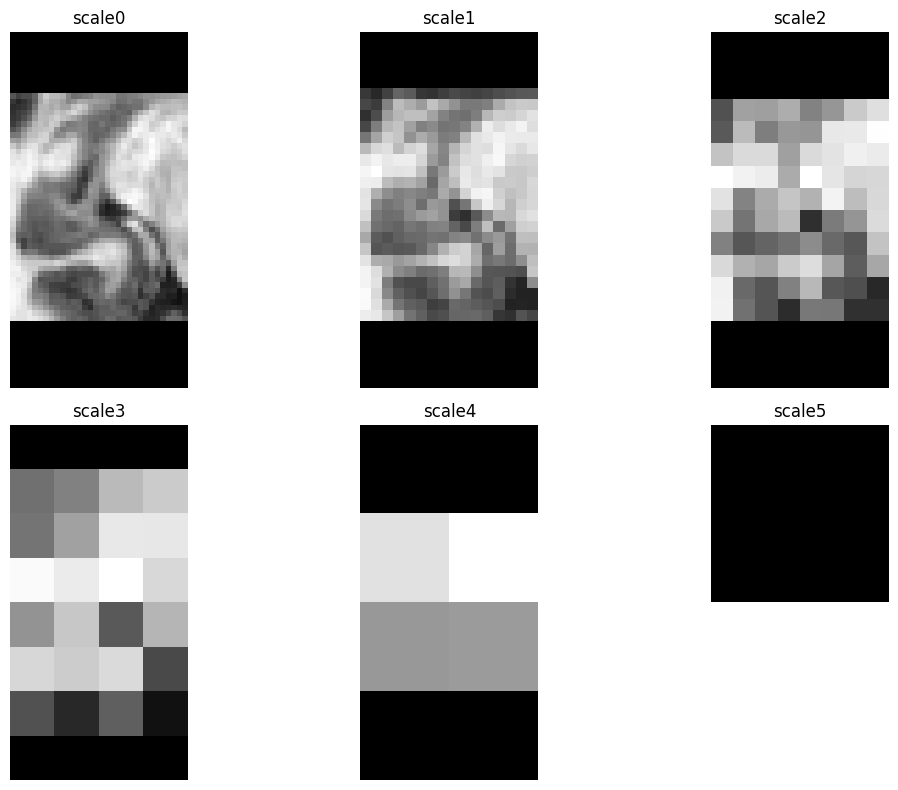

In [ ]:
# %% [markdown]
# Display Hippocampus Image at Multiple Scales
#
# This notebook loads a fixed hippocampus scan at several precomputed scales
# and displays the central axial slice for each in a grid layout.

# %%
import matplotlib.pyplot as plt
import nibabel as nib
import math
scales = [0, 1, 2, 3, 4, 5]
# %%
# Hard‑coded file paths for each scale
def get_paths():
    base = 'datasets/Task04_Hippocampus_Scaled/imagesTs'
    image = 'hippocampus_133'
    return [
        f"{base}/scale{i}/{image}.nii" for i in scales
    ]

paths = get_paths()
titles = [f'scale{i}' for i in range(len(paths))]

# %%
# Load each volume and extract the central axial slice
slices = []
for path in paths:
    img = nib.load(path)
    data = img.get_fdata()               # shape (X, Y, Z)
    z_mid = data.shape[2] // 2
    axial_slice = data[:, :, z_mid]      # shape (X, Y)
    slices.append(axial_slice)

# %%
# Plotting in a grid
n = len(slices)
cols = 3
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for ax, slc, title in zip(axes, slices, titles):
    ax.imshow(slc.T, cmap='gray', origin='lower')
    ax.set_title(title)
    ax.axis('off')

# Hide any unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
model_dir_str = "trained_models/ms-unet3d/Task01_BrainTumour/2025-05-07_23-36-36"
model_path, cfg = model_params(model_dir_str)


base_dir = Path("datasets/Task01_BrainTumour_Scaled")
img_dir = base_dir / "imagesTs" / f"scale0"
lbl_dir = base_dir / "labelsTs" / f"scale0"
img_dir_sort = sorted(os.listdir(img_dir))
lbl_dir_sort = sorted(os.listdir(lbl_dir))
test_dataset = BrainTumourDataset(cfg, "test", img_dir_sort, lbl_dir_sort, str(img_dir), str(lbl_dir))

setup_seed(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = instantiate(cfg.architecture.path, cfg)

checkpoint = torch.load(model_path, map_location=device)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

results_per_scale = {scale: [] for scale in [0, 1, 2, 3]}

for image, label in test_dataset:
    print(f"Image shape: {image.shape}")
    image_tensor = image.unsqueeze(0).to(device)
    
    segs, _ = model(image_tensor)
    for i in range(len(segs)):
        print(f"[Scale {i} | Image Shape {segs[i].shape}")
        preds = segs[i]
        pred = torch.argmax(preds, dim=1).squeeze(0)
        label = label.squeeze(0).to(device)
        downsampled_label = F.interpolate(
                    label.unsqueeze(0).unsqueeze(0).float(),
                    size=pred.shape,
                    mode="nearest",
                ).squeeze(0).squeeze(0)
        d = dice_coefficient(
            pred, downsampled_label, num_classes=cfg.dataset.num_classes, ignore_index=0
        )
        results_per_scale[i] += [d.item()]
print("Results per scale:")
for scale, results in results_per_scale.items():
    print(f"Scale {scale}: {results}")
    mean_dice = np.mean(results)
    std_dice = np.std(results)
    print(f"Mean Dice: {mean_dice:.4f}, Std Dice: {std_dice:.4f}")

image shape: (128, 256, 256, 4)
image shape: torch.Size([4, 128, 256, 256])
Image shape: torch.Size([4, 128, 256, 256])
[Scale 0 | Image Shape torch.Size([1, 4, 128, 256, 256])
[Scale 1 | Image Shape torch.Size([1, 4, 64, 128, 128])
[Scale 2 | Image Shape torch.Size([1, 4, 32, 64, 64])
[Scale 3 | Image Shape torch.Size([1, 4, 16, 32, 32])
image shape: (128, 256, 256, 4)
image shape: torch.Size([4, 128, 256, 256])
Image shape: torch.Size([4, 128, 256, 256])
[Scale 0 | Image Shape torch.Size([1, 4, 128, 256, 256])
[Scale 1 | Image Shape torch.Size([1, 4, 64, 128, 128])
[Scale 2 | Image Shape torch.Size([1, 4, 32, 64, 64])
[Scale 3 | Image Shape torch.Size([1, 4, 16, 32, 32])
image shape: (128, 256, 256, 4)
image shape: torch.Size([4, 128, 256, 256])
Image shape: torch.Size([4, 128, 256, 256])
[Scale 0 | Image Shape torch.Size([1, 4, 128, 256, 256])
[Scale 1 | Image Shape torch.Size([1, 4, 64, 128, 128])
[Scale 2 | Image Shape torch.Size([1, 4, 32, 64, 64])
[Scale 3 | Image Shape torch.Si

/home/si-hj/.conda/envs/bp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/si-hj/.conda/envs/bp/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/si-hj/.conda/envs/bp/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/si-hj/.conda/envs/bp/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/si-hj/.conda/envs/bp/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
